In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.animation as anim

from Libraries import thermodynamics as thermo

%matplotlib notebook

In [61]:
d = .8
d_min = 3.0 - d/2
d_max = 3.0 + d/2

y_max = 2.0
x_min = 0.
x_max = 6.

n_x = 101
n_y = 101

y = np.logspace(0,np.log(y_max+1),n_y,base=np.exp(1))
y -= 1
x = np.linspace(x_min,x_max,n_x)

y = np.insert(y,0,-.1)
y = np.append(y,y[-1]+.1)

x = np.insert(x,0,x_min-.1)
x = np.append(x,x_max+.1)

d_y = y[2:]-y[1:-1]

D_y = np.full((n_y,n_x),d_y)

d_x = x[2]-x[1]

jet = (np.greater_equal(x,d_min)*np.less_equal(x,d_max)).astype(int)
jin = np.invert(jet.astype(bool)).astype(int)

X,Y = np.meshgrid(x[1:-1],y[1:-1])

d_t = 0.0006

Nit = 50

air = thermo.FluidArray((n_y+2,n_x+2))
air.Fluid('air')

T0 = 300.0

air.get_properties(np.full((n_y+2,n_x+2),T0))
Mu = air.mu
Rho = air.rho

v0 = -5.0

In [44]:
def PresIter(p,u,v,dx,dy,dt,nit):
    pn = p.copy()
    
    co=0
    while co<nit:
        pn = p.copy()
        p[1:-1,1:-1] = (2*pn[1:-1,:-2]*dy**2*dt + 2*pn[1:-1,2:]*dy**2*dt + 2*dx**2*pn[:-2,1:-1]*dt + 2*dx**2*pn[2:,1:-1]*dt - \
                    dx**2*dy*v[2:,1:-1] +dx**2*dy*v[:-2,1:-1] -dx*dy**2*u[1:-1,2:] + dx*dy**2*u[1:-1,:-2])/(4*dt*(dx**2 + dy**2))
        p[:,0], p[:,-1], p[0,:], p[-1,:] = p[:,1],p[:,-2],p[1,:],p[-2,:]
        co+=1
    return p

def OneStep(u,v,dx,dy,dt,P,rho,mu,nit):
    un = u.copy()
    vn = v.copy()
    
    P = PresIter(P,u,v,dx,dy,dt,nit)
    
    u[1:-1,1:-1] = (un[1:-1,1:-1]*dt*dx*dy**2*rho[1:-1,1:-1]*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                    un[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*dx**2*vn[1:-1,1:-1]*dy*rho[1:-1,1:-1]*(-un[2:,1:-1] + \
                    un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                    dt*dx*dy**2*(-P[1:-1,2:] + P[1:-1,:-2])/2 + dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + \
                                                            un[1:-1,2:] + un[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])
    v[1:-1,1:-1] = (vn[1:-1,1:-1]*dt*dx**2*dy*rho[1:-1,1:-1]*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                    vn[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*un[1:-1,1:-1]*dx*dy**2*rho[1:-1,1:-1]*(-vn[1:-1,2:] + \
                    vn[1:-1,:-2])/2 + dt*dx**2*dy*(-P[2:,1:-1] + P[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + \
                    vn[2:,1:-1] + vn[:-2,1:-1]) + dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,2:] + \
                                                                         vn[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])
    
    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,1], u[:,-2], 0.0, u[-2,:]
    v[:,0], v[:,-1], v[0,:] = v[:,1], v[:,-2], 0.0
    v[-1,:] = v[-2,:]*jin + v0*jet
    
    return u,v,P

In [51]:
U = np.zeros((n_y+2,n_x+2))
V = np.zeros((n_y+2,n_x+2))
P = np.zeros((n_y+2,n_x+2))

U[0,:] = 0.0
V[0,:] = 0.0
#V[-int(n_y/2):,:] = v0*jet
V[-1,:] = v0*jet

#U,V,P = OneStep(U,V,d_x,D_y,d_t,P,Rho,Mu,Nit)

<IPython.core.display.Javascript object>


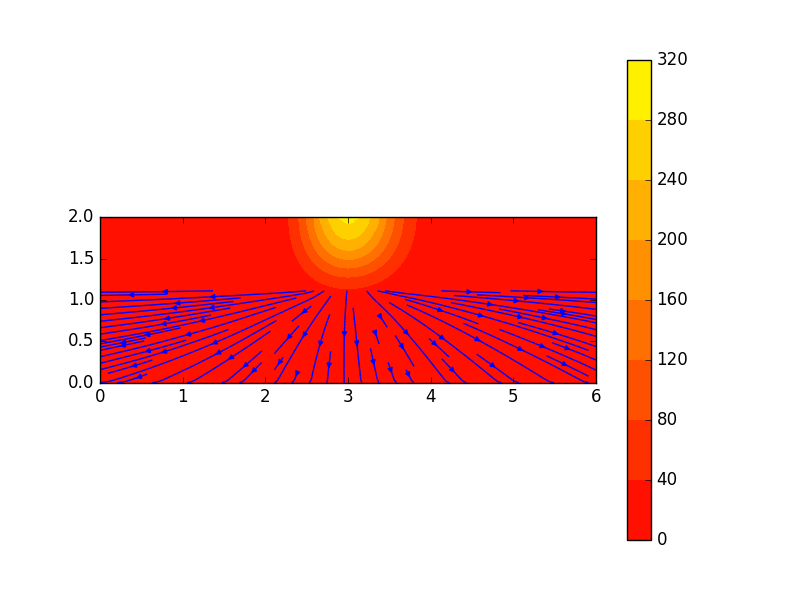

In [46]:
c=0
while c<5:
    U,V,P = OneStep(U,V,d_x,D_y,d_t,P,Rho,Mu,Nit)
    c+=1
f1 = pl.figure(dpi=100)
a1 = pl.gca()
a1.set_aspect('equal')
cf = a1.contourf(X,Y,P[1:-1,1:-1],cmap='autumn')
f1.colorbar(cf)
a1.streamplot(X[::2,::2],Y[::2,::2],U[1:-1:2,1:-1:2],V[1:-1:2,1:-1:2])


<IPython.core.display.Javascript object>


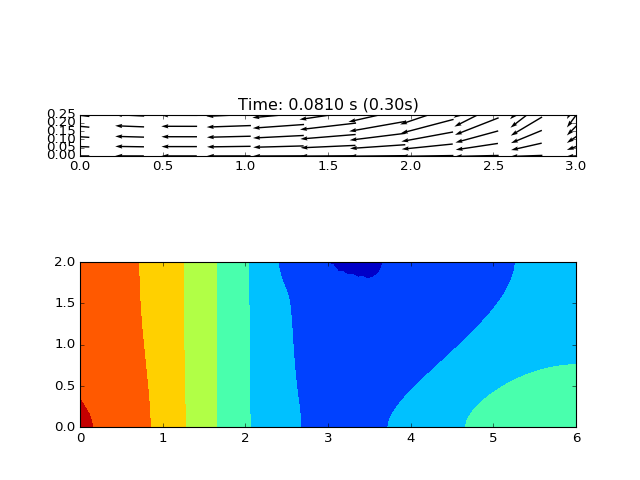

In [72]:
fig,[ax1,ax2] = pl.subplots(2)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

U = np.zeros((n_y+2,n_x+2))
V = np.zeros((n_y+2,n_x+2))
P = np.zeros((n_y+2,n_x+2))

U[0,:] = 0.0
V[0,:] = 0.0
V[-1,:] = v0*jet

#ax1.set_ylim(0,.25)
#ax1.set_xlim(0,3)

time_step = 50 #ms

jmp = 5

q = ax1.quiver(X[::jmp,::jmp],Y[::jmp,::jmp],U[1:-1:jmp,1:-1:jmp],V[1:-1:jmp,1:-1:jmp],scale=10,pivot='mid')
cf = ax2.contourf(X,Y,P[1:-1,1:-1])
#.set_UVC(u,v)

def animate(i,u,v,dx,dy,dt,P,rho,mu,nit):
    U,V,P = OneStep(u,v,dx,dy,dt,P,rho,mu,nit)
    
    q.set_UVC(U[1:-1:jmp,1:-1:jmp],V[1:-1:jmp,1:-1:jmp])
    title = 'Time: %.4f s (%.2fs)' %(dt*i,500*dt)
    ax1.set_title(title)
    ax2.cla()
    cf = ax2.contourf(X,Y,P[1:-1,1:-1])
    return q,ax2

ani = anim.FuncAnimation(fig,animate,np.arange(0,500),interval=time_step,blit=False,fargs=(U,V,d_x,D_y,d_t,P,Rho,Mu,Nit))
#ani.save('ImpJet_wrong.mp4') 

In [52]:
V

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -0., -0., -0., -5., -0., -0., -0., -0., -0., -0.]])

In [53]:
x

array([-0.1,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,
        6. ,  6.1])